# Test whether contamination as a categorical trait is unequally distributed across taxonomy using GTDB representatives

Using methods developed by Borges et al. (2019) (https://doi.org/10.1093/bioinformatics/bty800; https://github.com/mrborges23/delta_statistic), estimate whether contamination as a categorical trait has a phylogenetic signal, where phylogeny is estimated from taxonomy. This method uses Shannon entropy and a $\delta$ statistic to evaluate the degree of phylogenetic signal between a phylogeny and a categorical trait.

The $\delta$ value is higher when there is a higher degree of phylogenetic signal between a trait and a tree.

GTDB provides a tree for representative sequences, so this analysis is limited to representative sequences.

Naively, I would expect MAGs to have more contamination that isolate genomes, so I would expect contamination to be more strongly associated with branches of the tree that come exclusively from MAGs.

In [2]:
setwd("..")

In [7]:
install.packages("expm") # no build in conda for installation in env, but will install from CRAN

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [13]:
library(ape)
library(dplyr)
library(stringr)
library(readr)
library(tidyr)
source("scripts/delta_statistic.R")


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




## Read in GTDB metadata

In [14]:
gtdb_metadata <- read_tsv("inputs/gtdb/bac120_metadata_r202.tsv", show_col_types = F) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("GB_", "", accession)) %>%
  mutate(accession = gsub("RS_", "", accession))

Warning message:
“One or more parsing issues, see `problems()` for details”


## Read in charcoal results and annotate gene accessions by contaminated or not

In [15]:
charcoal <- read_csv("outputs/gtdb_rs202_charcoal1/stage1_hitlist.csv", show_col_types = F)%>%
  mutate(genome = gsub("_genomic.fna.gz", "", genome))

In [16]:
gtdb_metadata <- gtdb_metadata %>%
  mutate(order_lineage = paste(sep = ";", domain, phylum, class, order))

combined <- left_join(charcoal, gtdb_metadata, by = c("genome" = "accession")) %>%
  mutate(lineages_match = ifelse(lineage == order_lineage, T, F),
         charcoal_contamination_order = (order_bad_bp/genome_size)*100,
         charcoal_contamination_family = (family_bad_bp/genome_size)*100,
         charcoal_contamination_genus = (genus_bad_bp/genome_size)*100,
         contaminated_at_filter_rank = ifelse(order_bad_bp > 0, T, F))

## Download trees and preprocess

Note trees only contain representative sequences

In [18]:
bac_tree_destfile <- "inputs/gtdb/bac120_r202.tree"
url <- "https://data.gtdb.ecogenomic.org/releases/release202/202.0/bac120_r202.tree"
if (!file.exists(bac_tree_destfile)) {
  download.file(url, bac_tree_destfile, method="auto") 
}
gtdb_tree <- read.tree(bac_tree_destfile)

In [23]:
# drop tips from GTDB that haven't been decontaminated by charcoal yet. 
# this tree contains all GTDB species.
drop_tips <- gtdb_tree$tip.label[!str_detect(gtdb_tree$tip.label, paste(combined$genome, collapse="|"))]
gtdb_tree <- drop.tip(gtdb_tree, drop_tips)
# edit tip labels to remove GC/RS
gtdb_tree$tip.label <- gsub("RS_", "", gtdb_tree$tip.label) 
gtdb_tree$tip.label <- gsub("GB_", "", gtdb_tree$tip.label) 

In [28]:
# filter charcoal results to genomes that are included in the tree
# then reorder charcoal results to match tip label order
combined_filtered <- combined %>%
  filter(genome %in% gtdb_tree$tip.label)

combined_filtered <- combined_filtered[order(match(combined_filtered$genome, gtdb_tree$tip.label)), ]

all.equal(combined_filtered$genome, gtdb_tree$tip.label)

[1] TRUE

In [30]:
# garuntee that all branch lengths are positive in the tree
gtdb_tree$edge.length[gtdb_tree$edge.length==0] <- quantile(gtdb_tree$edge.length,0.1)*0.1

In [31]:
# calculate delta for contamination
delta_contam <- delta(combined_filtered$contaminated_at_filter_rank, gtdb_tree,0.1,0.0589,10000,10,100)

In [33]:
# calculate p value for delta
# shuffle the trait vector using the function delta (for 100 iterates) 
# create a vector of random deltas that will work as our null hypothesis. 
# Then compute the probability p(random_delta>delta_contam) in the null distribution, which returns the p-value.

random_delta <- rep(NA,100)
for (i in 1:100){
  rtrait <- sample(combined_filtered$contaminated_at_filter_rank)
  random_delta[i] <- delta(rtrait, gtdb_tree,0.1,0.0589,10000,10,100)
}
p_value <- sum(random_delta > delta_contam) / length(random_delta)

Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(solve(h))):
“NaNs produced”
Warning message in sqrt(diag(so

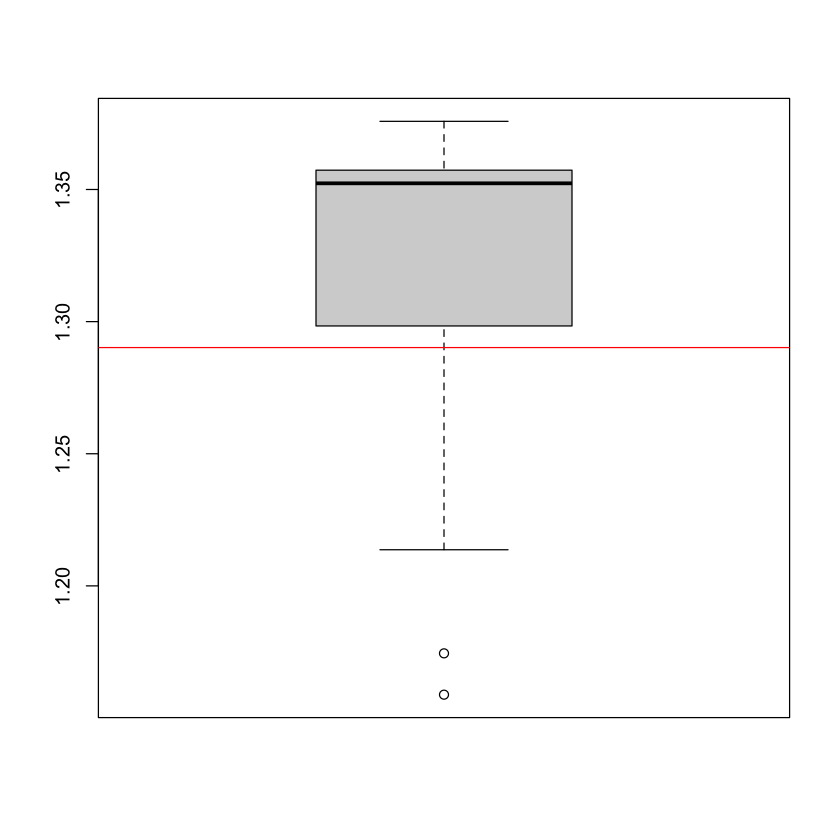

In [34]:
boxplot(random_delta)
abline(h=delta_contam, col="red")

In [35]:
p_value

[1] 0.79

## Next steps

+ Run on full GTDB
+ Visualize? May not be worth viz since the GTDB tree will be so large